<a href="https://colab.research.google.com/github/Shivp55/DAML/blob/main/ML_Notebook_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load label mappings
with open('/content/drive/MyDrive/ML/Dataset 3/Mars Surface Images Dataset/Mars Surface Dataset/msl_synset_words-indexed.txt', 'r') as f:
    class_mapping = {int(line.split()[0]): line.split()[1] for line in f}

# Display class mapping
print("Class Mapping:", class_mapping)


Class Mapping: {0: 'apxs', 1: 'apxs', 2: 'chemcam', 3: 'chemin', 4: 'drill', 5: 'drill', 6: 'drt', 7: 'drt', 8: 'ground', 9: 'horizon', 10: 'inlet', 11: 'mahli', 12: 'mahli', 13: 'mastcam', 14: 'mastcam', 15: 'observation', 16: 'portion', 17: 'portion', 18: 'portion', 19: 'rems', 20: 'rover', 21: 'scoop', 22: 'sun', 23: 'turret', 24: 'wheel'}


In [ ]:

test_inds = pd.read_csv("/content/drive/MyDrive/ML/Dataset 3/Mars Surface Images Dataset/Mars Surface Dataset/test-calibrated-shuffled.txt",header=None,delimiter=' ')
test_inds.columns = ['filepath','class']

test_inds['use'] = ['test'] * len(test_inds)

test_inds

,filepath,class,use
0,calibrated/0830MR0036510000500684E01_DRCL.JPG,7,test
1,calibrated/0640MH0002640000203781I01_DRCL.JPG,24,test
2,calibrated/0647MH0003250050203806E01_DRCL.JPG,9,test
3,calibrated/0844MR0037590000501001I01_DRCL.JPG,7,test
4,calibrated/0618MR0026460020401253I01_DRCL.JPG,11,test
...,...,...,...
1300,calibrated/0571MH0002590000201894I01_DRCL.JPG,24,test
1301,calibrated/0840ML0037090000401385I01_DRCL.JPG,17,test
1302,calibrated/0868MH0003900000302200I01_DRCL.JPG,10,test
1303,calibrated/0568MH0002630000201882E01_DRCL.JPG,24,test


In [ ]:
train_inds = pd.read_csv("/content/drive/MyDrive/ML/Dataset 3/Mars Surface Images Dataset/Mars Surface Dataset/train-calibrated-shuffled.txt",header=None,delimiter=' ')
train_inds.columns = ['filepath','class']

train_inds['use'] = ['train'] * len(train_inds)

train_inds

,filepath,class,use
0,calibrated/0077ML0005780000102730I01_DRCL.JPG,15,train
1,calibrated/0072MR0005610170103642E01_DRCL.JPG,8,train
2,calibrated/0069MR0004130000103477I01_DRCL.JPG,21,train
3,calibrated/0154ML0008510010104492E01_DRCL.JPG,8,train
4,calibrated/0019MR0000530000100138C00_DRCL.JPG,8,train
...,...,...,...
3741,calibrated/0163ML0008760050104602D01_DRCL.JPG,10,train
3742,calibrated/0072MR0005620000103655E01_DRCL.JPG,8,train
3743,calibrated/0066ML0003650000102517M00_DRCL.JPG,21,train
3744,calibrated/0157ML0008550020104531I01_DRCL.JPG,8,train


In [ ]:
val_inds = pd.read_csv("/content/drive/MyDrive/ML/Dataset 3/Mars Surface Images Dataset/Mars Surface Dataset/val-calibrated-shuffled.txt",header=None,delimiter=' ')
val_inds.columns = ['filepath','class']

val_inds['use'] = ['validation'] * len(val_inds)

val_inds


,filepath,class,use
0,calibrated/0292MH0002810020103587C00_DRCL.JPG,5,validation
1,calibrated/0270MH0002530050102760I01_DRCL.JPG,5,validation
2,calibrated/0549MH0002620000201566E01_DRCL.JPG,24,validation
3,calibrated/0229MR0009720000202913E01_DRCL.JPG,0,validation
4,calibrated/0292MH0002810020103613C00_DRCL.JPG,5,validation
...,...,...,...
1635,calibrated/0486MR0011580000302944E01_DRCL.JPG,0,validation
1636,calibrated/0506MH0002240020200655I01_DRCL.JPG,8,validation
1637,calibrated/0229MR0010840000202939I01_DRCL.JPG,16,validation
1638,calibrated/0229MR0009760000202918I01_DRCL.JPG,18,validation


In [ ]:

all_images_df = pd.concat([test_inds,val_inds,train_inds],ignore_index=True)

surface = [5,8,9]
all_images_df['class'] = ["Surface" if (c in surface) else "Rover" for c in all_images_df['class']]

all_images_df

,filepath,class,use
0,calibrated/0830MR0036510000500684E01_DRCL.JPG,Rover,test
1,calibrated/0640MH0002640000203781I01_DRCL.JPG,Rover,test
2,calibrated/0647MH0003250050203806E01_DRCL.JPG,Surface,test
3,calibrated/0844MR0037590000501001I01_DRCL.JPG,Rover,test
4,calibrated/0618MR0026460020401253I01_DRCL.JPG,Rover,test
...,...,...,...
6686,calibrated/0163ML0008760050104602D01_DRCL.JPG,Rover,train
6687,calibrated/0072MR0005620000103655E01_DRCL.JPG,Surface,train
6688,calibrated/0066ML0003650000102517M00_DRCL.JPG,Rover,train
6689,calibrated/0157ML0008550020104531I01_DRCL.JPG,Surface,train


In [ ]:

print("Number of Images: ",len(all_images_df))
print("Number of Images in Train Set", len(all_images_df[all_images_df['use'] == 'train']))
print("Number of Images in Validation Set", len(all_images_df[all_images_df['use'] == 'validation']))
print("Number of Images in Test Set", len(all_images_df[all_images_df['use'] == 'test']))

Number of Images:  6691
Number of Images in Train Set 3746
Number of Images in Validation Set 1640
Number of Images in Test Set 1305


In [ ]:

def createDirectory():
  data_path = "/content/drive/MyDrive/ML/Dataset 3/Mars Surface Images Dataset/Mars Surface Dataset/dataset/"
  folders = ['train','test','validation']
  classes = ['Surface','Rover']

  # make new directories if doesn't exist
  for f in folders:
    for i in classes:
      newpath = data_path + f + "/" + str(i)
      if not os.path.exists(newpath):
          os.makedirs(newpath)

  # defining test source and destination
  src = '/content/drive/MyDrive/ML/Dataset 3/Mars Surface Images Dataset/Mars Surface Dataset/'
  trg = '/content/drive/MyDrive/ML/Dataset 3/Mars Surface Images Dataset/Mars Surface Dataset/dataset/'

  for x in range(len(all_images_df)):
    class_label = all_images_df['class'][x]
    folder_name = all_images_df['use'][x]

    from_fp = all_images_df['filepath'][x]
    to_fp = trg + folder_name + "/" + class_label

    print(from_fp)
    print(to_fp)
    print('----------------------')

    shutil.copy2(os.path.join(src,from_fp), to_fp)

#createDirectory()

In [ ]:
# Load Dataset
batch_size = 32
img_height, img_width = 224, 224  # Match the input size for EfficientNetB0
base_dir = "/content/drive/MyDrive/ML/Dataset 3/Mars Surface Images Dataset/Mars Surface Dataset/dataset/"

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'validation'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3746 files belonging to 2 classes.
Found 1640 files belonging to 2 classes.
Found 1305 files belonging to 2 classes.


In [ ]:

# Build CNN Model for Classification
model1 = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Reduce overfitting
    layers.Dense(2, activation='softmax')
])
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train Model
history1 = model1.fit(train_ds, validation_data=val_ds, epochs=15, callbacks=[early_stopping])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 622s 2s/step - accuracy: 0.7812 - loss: 0.6378 - val_accuracy: 0.8299 - val_loss: 0.3547
Epoch 2/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9270 - loss: 0.1727 - val_accuracy: 0.8591 - val_loss: 0.3477
Epoch 3/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9601 - loss: 0.1167 - val_accuracy: 0.8524 - val_loss: 0.3154
Epoch 4/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9584 - loss: 0.1257 - val_accuracy: 0.8896 - val_loss: 0.2375
Epoch 5/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9786 - loss: 0.0728 - val_accuracy: 0.8409 - val_loss: 0.3984
Epoch 6/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9780 - loss: 0.0601 - val_accuracy: 0.8909 - val_loss: 0.2795
Epoch 7/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9817 - loss: 0.0622 - val_accuracy: 0.9030 - val_loss: 0.2908
Epoch 8/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9863 - loss: 0.0487 - val_ac

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
# Evaluate on Test Set
test_loss, test_acc = model1.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

In [ ]:
# Load EfficientNetB0 with Pre-Trained Weights
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))

# Freeze Base Model
base_model.trainable = False

# Build Model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduce feature maps to a single vector
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(2, activation='softmax')  # Output layer for binary classification
])

# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stopping, reduce_lr]
)

# Fine-Tune (Unfreeze Base Model)
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
fine_tune_history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 51s 250ms/step - accuracy: 0.9541 - loss: 0.0878 - val_accuracy: 0.9963 - val_loss: 0.0229 - learning_rate: 0.0010
Epoch 2/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9973 - loss: 0.0079 - val_accuracy: 0.9939 - val_loss: 0.0253 - learning_rate: 0.0010
Epoch 3/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9995 - loss: 0.0028 - val_accuracy: 0.9951 - val_loss: 0.0234 - learning_rate: 0.0010
Epoch 4/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9989 - loss: 0.0030 - val_accuracy: 0.9963 - val_loss: 0.0192 - learning_rate: 0.0010
Epoch 5/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.9963 - val_loss: 0.0223 - learning_rate: 0.0010
Epoch 6/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.9986 - loss: 0.0030 - val_accuracy: 0.9970 - val_loss: 0.0249 - learning_rate: 0.0010
Epoch 7/15
118/118 ━━━━━━━━

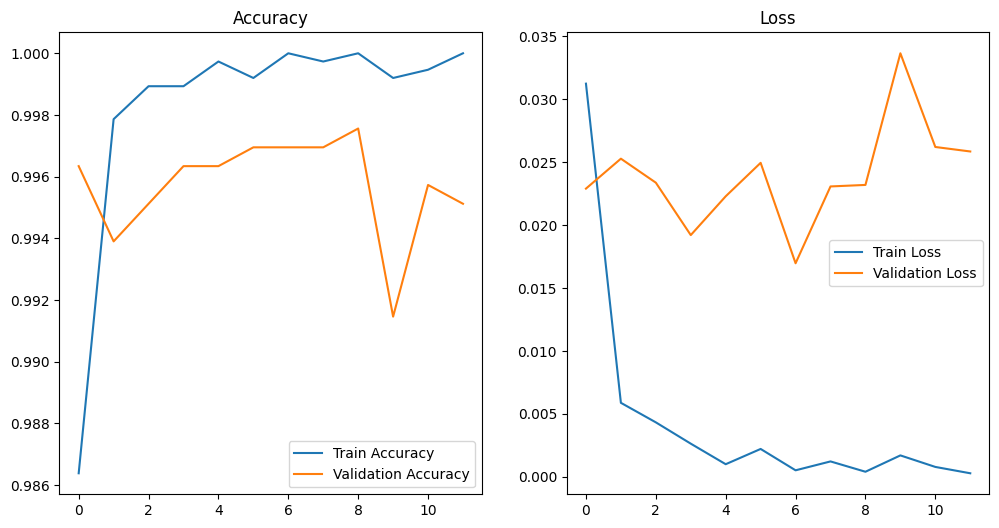

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
# Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")



41/41 ━━━━━━━━━━━━━━━━━━━━ 200s 5s/step - accuracy: 0.9267 - loss: 0.2317
Test Accuracy: 0.93


In [ ]:
# Classification Report
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)
print(classification_report(y_true, y_pred))

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step
              precision    recall  f1-score   support

           0       0.92      1.00      0.95       979
           1       0.98      0.72      0.83       326

    accuracy                           0.93      1305
   macro avg       0.95      0.86      0.89      1305
weighted avg       0.93      0.93      0.92      1305



In [ ]:
# Clustering using PCA + KMeans
X_train_flat = np.concatenate([x.numpy().reshape((x.shape[0], -1)) for x, _ in train_ds])
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_train_flat)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# Visualize Clustering
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title("PCA + KMeans Clustering")
plt.show()

NameError: name 'np' is not defined